In [1]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
import tt

class SimplePDE:
  """
  Solve simple diffusion problem on [0,1] using P1 finite elements.
  """

  def __init__(self, N):
    self.N = N

  def linear_system(self, k, coeff):
    """
    Assemble k-th component of linear system (depending on k-th component of 
    coefficient.
    """
    if k == 0:
      [num_coeff, nx, I] = np.shape(coeff)

      coeff = coeff[0,:,:]

      if np.min(coeff) <= 0:
        warnings.warn(f'Non positive components')
      
      A = [None] * I
      F = [None] * I
      U = []

      for i in range(I):
        # part of rhs dependent on coeff (0 here)
        Fi = np.zeros((self.N+1,1))
        F[i]= Fi
        
        # assemble A, coeff piecewise constant on grid
        # first part linearly dependent on coeff
        Ai = np.zeros((self.N+1,self.N+1))
        Ai.flat[self.N+2::self.N+2] = (coeff[1:,i] + coeff[:-1, i]) * self.N # set diag
        Ai.flat[1::self.N+2] = -coeff[:,i] * self.N # set first upper diag
        Ai.flat[self.N+1::self.N+2] = -coeff[:,i] * self.N # set first lower diag
        Ai[[0,-1]] = 0
        A[i] = Ai
      
      return A, F
      
    elif k == 1: # constant part
      [num_coeff, nx, I] = np.shape(coeff)
      
      A = [None] * I
      F = [None] * I
      U = []

      for i in range(I):
        # constant part of rhs
        Fi = np.full((self.N+1,1), 10/(self.N)) # assume RHS = 1 
        Fi[[0,-1]] = 0 # boundary condition
        F[i] = Fi
        
        # constant part of matrix (from boundary condition)
        Ai = np.zeros((self.N+1,self.N+1))
        Ai[0,0] = 1
        Ai[-1,-1] = 1
        A[i] = Ai
      
      return A, F
    else:
      raise Exception(f"No component {k} != 0,1 implemented.")

  def solve(self, coeff):
    """
    Assemble and solve FE problem for coeff.
    """
    [num_coeff, nx, I] = np.shape(coeff[0])
    
    U = []

    A0, b0 = self.linear_system(0, coeff[0])
    A1, b1 = self.linear_system(1, coeff[1])
    
    for i in range(I):
      U.append(np.linalg.solve(A0[i] + A1[i], b0[i] + b1[i]).reshape((-1,1)))
    
    return U


def coeff(X, Nx, Ny, offset, var):
  c = np.full(len(X), offset,dtype=float)
  for i, x in enumerate(X):
    # print(i)
    for k in range(1, len(x)):
      c[i] += np.exp(-k) * np.sin(np.pi*k*x[0]/(Nx-1)) * (x[k]/(Ny-1) - 0.5) * var
  return c

### PDE test

Solve the PDE using P1 finite elements for a random parameter

Text(0, 0.5, 'A')

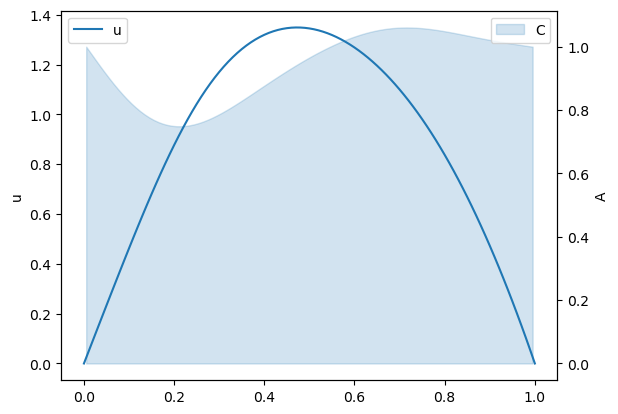

In [2]:
Nx = 100      # spatial resolution
Ny = 10       # parameter resolution
n_param = 5   # number of parameters
offset = 1   # parameter mean
var = 4       # 'variance' of the parameters

# get random params
y = np.random.randint(0,Ny, n_param)
X = np.hstack([np.arange(Nx).reshape((-1,1)), np.tile(y, [Nx,1])])

cfun = lambda x : coeff(x, Nx, Ny, offset, var)

C_true = cfun(X)

PDE_fun = SimplePDE(Nx)

U = PDE_fun.solve([C_true.reshape(1,-1,1), np.ones((1,1,1))])
U = np.ravel(U[0])

fig, ax = plt.subplots()
ax2 = ax.twinx()

x = np.arange(Nx+1) / Nx
midpoints = (np.arange(Nx) + 0.5) / Nx
p = ax.plot(x, U, label='u')
ax2.fill_between((np.arange(len(C_true)) + 0.5) / (len(C_true)), C_true, alpha=0.2, color=p[0].get_color(), label='C')

ax.set_ylabel('u')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
ax2.set_ylabel('A')

### Get TT approx of coefficient

In [3]:
from tt import cross

# random init tensor
C = tt.rand(np.array([Nx] + [Ny] * n_param),r=3)
# compute TT approx using TT-cross
C = tt.cross.rect_cross.cross(cfun, C, eps = 1e-8, kickrank=1)
C = C.round(1e-12)

print("Coefficient ranks: ", C.r)
print("Coefficient dims: ", C.n)

swp: 0/9 er_rel = 1.2e+01 er_abs = 3.9e+04 erank = 5.0 fun_eval: 2160
swp: 1/9 er_rel = 1.2e-01 er_abs = 3.9e+02 erank = 9.1 fun_eval: 7560
swp: 2/9 er_rel = 1.1e-15 er_abs = 3.8e-12 erank = 14.7 fun_eval: 21600
Coefficient ranks:  [1 6 5 4 3 2 1]
Coefficient dims:  [100  10  10  10  10  10]


### Test TT approx

Compare TT approx of coefficient $A$ vs the true coefficient $A$ for the random parameter sample from above

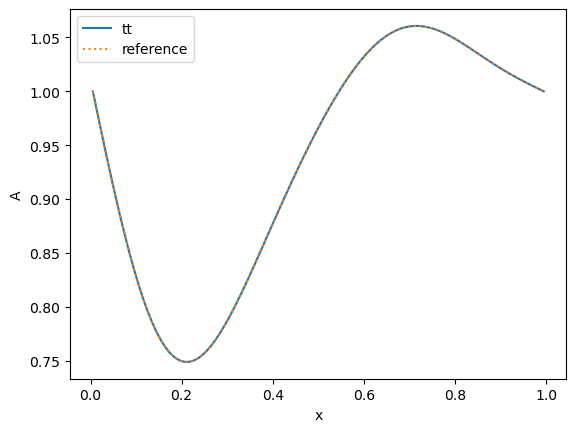

In [4]:
# eval TT-approx of coeff
C_eval = np.empty(Nx)
for i in range(Nx):
  C_eval[i] = C[np.concatenate((np.array([i]), y))]

fig, ax = plt.subplots()

x = (np.arange(0, Nx) + .5) / Nx
ax.plot(x, C_eval, label='tt')
ax.plot(x, C_true, ls='dotted', label="reference")
ax.set_xlabel('x')
ax.set_ylabel('A')
ax.legend()

In [5]:
# helper tensor that is filled with ones
cores = [np.ones((1,1,1))]
for i in range(n_param):
  cores += [np.ones((1,Ny,1))]

C_const = tt.vector.from_list(cores)

### ALS-cross test

In [6]:
from als_cross import als_cross

test = als_cross(
  [C, C_const], 
  PDE_fun,
  1e-8,
  kickrank=5
  )

test.iterate(3)

print(test.get_stats())

= swp=1 core 0, max_dx=1.000e+00, max_rank = 6
= swp=1 core 1>, dx=1.000e+00, rank = [11, 9]
= swp=1 core 2>, dx=1.000e+00, rank = [9, 7]
= swp=1 core 3>, dx=1.000e+00, rank = [7, 5]
= swp=1 core 4>, dx=1.000e+00, rank = [5, 4]
= swp=1 fwd finish, max_dx=1.000e+00, max_rank = 11
= swp=2 core <5, dx=0.000e+00, rank = [5, 1]
= swp=2 core <4, dx=1.153e-06, rank = [7, 5]
= swp=2 core <3, dx=1.250e-04, rank = [10, 7]
= swp=2 core <2, dx=1.667e-03, rank = [13, 10]
= swp=2 core <1, dx=8.437e-03, rank = [16, 13]
= swp=3 core 0, max_dx=2.465e-02, max_rank = 16
= swp=3 core 1>, dx=7.196e-03, rank = [21, 17]
= swp=3 core 2>, dx=7.183e-03, rank = [17, 13]
= swp=3 core 3>, dx=4.724e-04, rank = [13, 9]
= swp=3 core 4>, dx=3.889e-05, rank = [9, 6]
= swp=3 fwd finish, max_dx=7.196e-03, max_rank = 21
{'t_solve': 0.0020087909942958504, 't_project': 0.00037811500078532845, 'n_PDE_eval': 22}


### Test ALS-cross accuracy

Compare ALS cross approximation vs PDE solution for a random sample

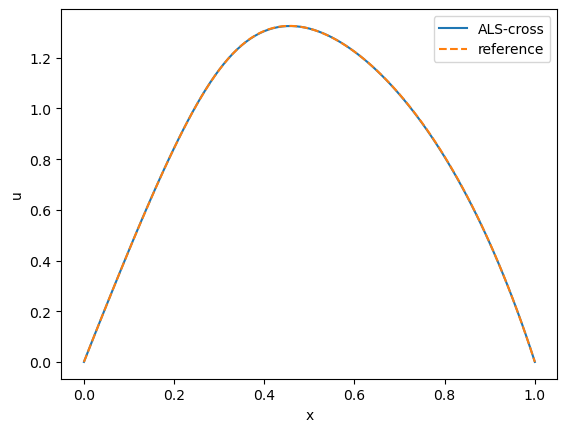

In [10]:
# get random parameter
y = np.random.randint(0,Ny, n_param)
X = np.hstack([np.arange(100).reshape((-1,1)), np.tile(y, [100,1])])

C_true = cfun(X) # compute true coeff

U = PDE_fun.solve([C_true.reshape(1,-1,1), np.zeros((1,1,1))]) # solve PDE
U = np.ravel(U)

# eval ALS-cross
u = test.get_tensor()
U_eval = np.empty(u.n[0])
for i in range(u.n[0]):
  U_eval[i] = u[np.concatenate((np.array([i]), y))]

fig, ax = plt.subplots()

x = np.arange(0, Nx+1) / Nx
ax.plot(x, U_eval, label='ALS-cross')
ax.plot(x, U, ls='dashed', label='reference')
ax.set_xlabel('x')
ax.set_ylabel('u')
ax.legend()